# Document Topic Classification
By: Angela Gao (angelazgao@gmail.com)

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

In [3]:
#stripping out metadata so that only textual features will be used
#restricting documents to 4 specific topics
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

#By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets. 
#If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Print out some text examples

In [5]:
def example(num_examples=5):
    
    # loop through and print training data and labels 
    for i in range(num_examples):
        print(train_data[i])
        print('\nTraining Label: ' + str(train_labels[i]))
        print('-'*100)
        
example(5)

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

Training Label: 1
----------------------------------------------------------------------------------------------------


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh h

### Tranforming training data into feature vectors

In [6]:
def transform_fv():
    
    # tranform into matrix of word unigram feature vectors
    vectorizer = CountVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    print("Vocab Size: ", vtrain.shape)
    print("Avg Number of Non-zero: ", round(vtrain.nnz/vtrain.shape[0],2))
    print("Fraction of Non-zero: ", round(vtrain.nnz/(vtrain.shape[0]*vtrain.shape[1]),4))
    print("Feature Strings: ", repr(vectorizer.get_feature_names()[0]), repr(vectorizer.get_feature_names()[-1]))
    print('-'*40)
    
    # using your own four word vocabulary
    vectorizer1 = CountVectorizer(vocabulary=["atheism", "graphics", "space", "religion"])
    vtrain1 = vectorizer1.transform(train_data)
    print("My Own Vocabulary\nVocab Size: ", vtrain1.shape)
    print("Avg Number of Non-zero: ", round(vtrain1.nnz/vtrain1.shape[0],2))
    print('-'*40)
    
    # tranform into matrix of character bigram and trigram feature vectors
    vectorizer2 = CountVectorizer(analyzer="char", ngram_range=(2,3))
    vtrain2 = vectorizer2.fit_transform(train_data)
    print("Character Bigram and Trigram\nVocab Size: ", vtrain2.shape)
    print('-'*40)
    
    # tranform into matrix of word unigram feature vectors while pruning uncommon words (<10 documents)
    vectorizer3 = CountVectorizer(min_df=10)
    vtrain3 = vectorizer3.fit_transform(train_data)
    print("Prune Words < 10\nVocab Size: ", vtrain3.shape)
    print('-'*40)
    
    # tranform into matrix of word unigram feature vectors
    print("Training Vocabulary: ",len(vectorizer.vocabulary_.keys()))
    training_vocab = vectorizer.vocabulary_.keys()
    
    vdev = vectorizer.fit_transform(dev_data)
    print("Development Vocabulary: ",len(vectorizer.vocabulary_.keys()))
    development_vocab = vectorizer.vocabulary_.keys()
    
    # compare training vocabulary to development vocabulary
    print("Words in Dev Data not in Training Data: ", len([i for i in development_vocab if i not in training_vocab]))
    

transform_fv()

Vocab Size:  (2034, 26879)
Avg Number of Non-zero:  96.71
Fraction of Non-zero:  0.0036
Feature Strings:  '00' 'zyxel'
----------------------------------------
My Own Vocabulary
Vocab Size:  (2034, 4)
Avg Number of Non-zero:  0.27
----------------------------------------
Character Bigram and Trigram
Vocab Size:  (2034, 35478)
----------------------------------------
Prune Words < 10
Vocab Size:  (2034, 3064)
----------------------------------------
Training Vocabulary:  26879
Development Vocabulary:  16246
Words in Dev Data not in Training Data:  4027


### Train word unigram feature vectors on K-NN, NB, Logistic Regression

In [8]:
def unigram_classify():
    
    # transform training and development data
    vectorizer = CountVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    
    # define a function to fit, predict, and output model f1 scores
    def fitting_models(model, x, name):
        mod = model
        mod.fit(vtrain, train_labels)
        pred_labels = mod.predict(vdev)
        print(name, " = %s, f1-score: "%x, metrics.f1_score(dev_labels, pred_labels, average='weighted'))
    
    # run for k-NN at different k values
    k_val = [1,3,5,7,9]
    for k in k_val:
        fitting_models(KNeighborsClassifier(k), k, 'k')
    print('-'*40)
    print("k-Nearest Neighbors: best k = 7\n")
    
    # run for NB at different alphas
    alphas = [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
    for a in alphas:
        fitting_models(MultinomialNB(alpha=a), a, 'alpha')
    print('-'*40)    
    print("Naive Bayes: best alpha = 0.1\n")
    
    # run for logistic at different regularization levels
    C = [0.001, 0.1, 0.5, 1.0, 2.0, 5.0]
    for c in C:
        log_mod = LogisticRegression(C=c, solver='liblinear', multi_class='auto')
        fitting_models(log_mod, c, 'C')
        
        # also output sum of squared weights for each topic
        ssw = []
        for l in log_mod.coef_:
            ssw.append(sum(i**2 for i in l))            
        print("Topic Sum of Squared Weights: ", ssw)
    print('-'*80)
    print("Logistic Regression: best C = 0.5\n")
    
unigram_classify()

k  = 1, f1-score:  0.3805030018531525
k  = 3, f1-score:  0.4084150225437623
k  = 5, f1-score:  0.4287607236218357
k  = 7, f1-score:  0.45047910006117586
k  = 9, f1-score:  0.4365666176198027
----------------------------------------
k-Nearest Neighbors: best k = 7

alpha  = 1e-10, f1-score:  0.747240657284563
alpha  = 0.0001, f1-score:  0.7628348704826354
alpha  = 0.001, f1-score:  0.7702518836155706
alpha  = 0.01, f1-score:  0.7751663218544357
alpha  = 0.1, f1-score:  0.7903052385098862
alpha  = 0.5, f1-score:  0.7862862961995258
alpha  = 1.0, f1-score:  0.7777320236017224
alpha  = 2.0, f1-score:  0.7689966472342658
alpha  = 10.0, f1-score:  0.6674814338256576
----------------------------------------
Naive Bayes: best alpha = 0.1

C  = 0.001, f1-score:  0.6193046812006844
Topic Sum of Squared Weights:  [0.16509345166829453, 0.20095274690581957, 0.1806709375439675, 0.18724278437848996]
C  = 0.1, f1-score:  0.6966243542418833
Topic Sum of Squared Weights:  [27.12949732751071, 24.65904426

### Train word bigram feature vectors on Logistic Regression

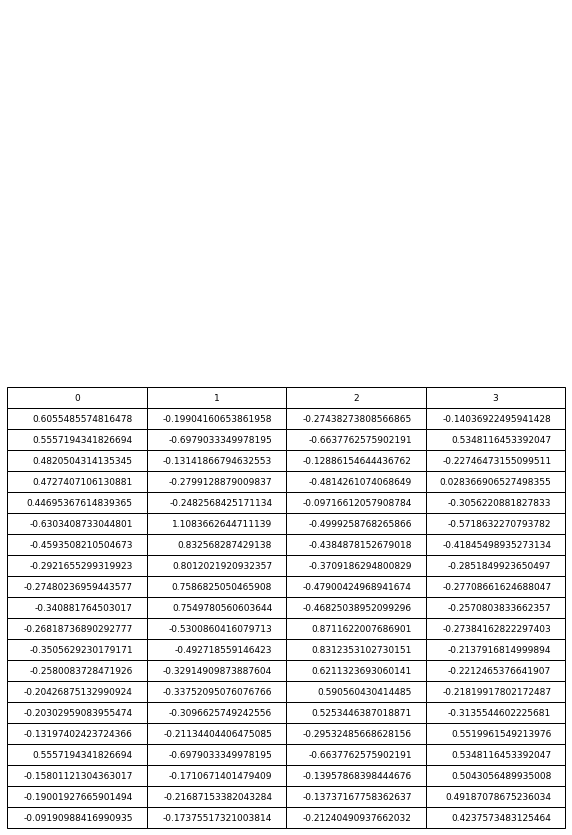

In [9]:
def logistic_weights():
    
    # transform training data
    vectorizer = CountVectorizer(ngram_range=(2,2))
    vtrain = vectorizer.fit_transform(train_data)
    
    # fit logistic regression model and get weights
    mod = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
    mod.fit(vtrain, train_labels)
    weights = mod.coef_
    
    # find the feature indices of the top 5 largest weights for each topic
    f_index = [i[:5] for i in np.argsort(weights*-1, axis=1)]
    index = np.concatenate(f_index, axis=0)
    
    # 20 features for each of the 4 topics
    w = [i[index] for i in weights]
    
    # using plt to generate table
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.table(cellText = np.transpose(w), colLabels = ['0','1','2','3'])
    fig.set_size_inches(10,7)


logistic_weights()
#For each topic (1-4), output the 5 features with the largest weights (that's 20 features in total)

It is suprisingly easy to distinguish which features are the most heavily weighted from each topic (i.e. first five in topic 0). A majority of the heavily weighted features that are taken from the other topics have negative weights. This is promising since this means that the major features that help define each topic is not prevalent in the other topics.

### Improve Logistic model with preprocessing

In [10]:
def better_preprocessor(s):
    
    s = s.lower() # lower case
    s = re.sub("_","",s) # remove underscores
    s = re.sub("\d+","X",s) # replace all digits with X
    
    w = re.split("\s", s) # split text into list of words
    
    # looping through each word in the list
    for i in range(len(w)):
        
        # remove very short words (<3 characters)
        if len(w[i]) <= 3:
            w[i] = 'x'
            
        # remove extra letters for long words (>6 characters)
        elif len(w[i]) > 6:
            w[i] = w[i][:6]
    
    # join back into a string
    return " ".join(w)

In [11]:
def with_preprocessor():
    
    # transform training and development data without pre-processing
    vectorizer = CountVectorizer()
    vtrain1 = vectorizer.fit_transform(train_data)
    vdev1 = vectorizer.transform(dev_data)
    
    # run logistic regression and print f1 score + dictionary size
    mod1 = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
    mod1.fit(vtrain1, train_labels)
    pred_labels1 = mod1.predict(vdev1)
    print("Logistic Regression\nf1-score: ", metrics.f1_score(dev_labels, pred_labels1, average='weighted'))
    print("dictionary size: ", len(vectorizer.vocabulary_))
    
    # trasnform training and development data with pre-processing, better_preprocessor
    p_vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    vtrain2 = p_vectorizer.fit_transform(train_data)
    vdev2 = p_vectorizer.transform(dev_data)
    
    # run logistic regression on pre-processed data
    mod2 = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto')
    mod2.fit(vtrain2, train_labels)
    pred_labels2 = mod2.predict(vdev2)
    
    # print f1 score + dictionary size of improved model
    print("Logistic Regression w/ Preprocessed Data\nf1-score: ", metrics.f1_score(dev_labels, pred_labels2, average='weighted'))
    print("dictionary size: ", len(p_vectorizer.vocabulary_))
    
with_preprocessor()

Logistic Regression
f1-score:  0.710072965652832
dictionary size:  26879
Logistic Regression w/ Preprocessed Data
f1-score:  0.7325117047374619
dictionary size:  17785


### L1, L2 Regularization

Regularization avoids learning very large weights (risk overfitting) by adding a penalty to the total size of the learned weights.

- The default L2 regularization computes this size as the sum of the squared weights, making all the weights relatively small.
- L1 regularization computes this size as the sum of the absolute values of the weights, driving most weights to 0. (Good for feature selection)

In [12]:
# Keep this random seed here to make comparison easier.
np.random.seed(0)
    
# Using L1 regularization produced a logistic regression model, reducing vocabulary to features that have at least one non-zero weight in the four categories
# Use reduced vocab and L2 regularization of 0.5 for a new logistic regression model
def regularization(c):
    
    # transform training data
    vectorizer = CountVectorizer()
    vtrain1 = vectorizer.fit_transform(train_data)
        
    # fit logistic regression for L1 regularization to get weights
    mod1 = LogisticRegression(C=c, solver='liblinear', multi_class='auto', penalty="l1")
    mod1.fit(vtrain1, train_labels)
    weights = mod1.coef_
        
    # keep index of features where at least one of the weights is non-negative
    index = []
    for topic in weights:
        [index.append(i) for i, e in enumerate(topic) if e != 0 and i not in index]
        
    # using the index get a list of the reduced vocabulary
    my_vocab = list(vectorizer.vocabulary_.keys())
    my_vocab = [my_vocab[i] for i in index]
        
    # transform training and development data using the new reduced vocabulary
    v_vectorizer = CountVectorizer(vocabulary = my_vocab)
    vtrain2 = v_vectorizer.fit_transform(train_data)
    vdev = v_vectorizer.transform(dev_data)
        
    # fit logistic regression for L2 regularization with the reduced vocabulary 
    mod2 = LogisticRegression(C=0.5, solver='liblinear', multi_class='auto', penalty="l2", tol=0.015)
    mod2.fit(vtrain2, train_labels)
    pred_labels = mod2.predict(vdev)
        
    # return the f1 score and vocabulary size 
    return metrics.f1_score(dev_labels, pred_labels, average='weighted'), len(v_vectorizer.vocabulary_)

In [13]:
# now taking various levels of C for our plot
c_values = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
f1_score = []
vocab_size = []
    
# run our regularization function 
# print the f1 score, regularization level, and vocab size for the new model
print("Logistic Regression w/ L2 Regularization and Reduced Vocabulary\n")
for c in c_values:
    print("L1 Regularization strength: ", c)
    a,b = regularization(c)
    print("f1-score: ", a)
    f1_score.append(a)
    print("dictionary size: ", b)
    vocab_size.append(b)
    print('-'*40)
log_vocab = [np.log(i) for i in vocab_size]

Logistic Regression w/ L2 Regularization and Reduced Vocabulary

L1 Regularization strength:  0.001
f1-score:  0.13390025359256127
dictionary size:  2
----------------------------------------
L1 Regularization strength:  0.01
f1-score:  0.1371339497943034
dictionary size:  16
----------------------------------------
L1 Regularization strength:  0.1
f1-score:  0.18523944122288885
dictionary size:  206
----------------------------------------
L1 Regularization strength:  0.5


/Users/okcat/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


f1-score:  0.3279388154822125
dictionary size:  704
----------------------------------------
L1 Regularization strength:  1.0
f1-score:  0.3713014147868266
dictionary size:  971
----------------------------------------
L1 Regularization strength:  2.0
f1-score:  0.42591853736732804
dictionary size:  1319
----------------------------------------
L1 Regularization strength:  5.0
f1-score:  0.4975203368868527
dictionary size:  2518
----------------------------------------
L1 Regularization strength:  10.0
f1-score:  0.49423391959957064
dictionary size:  2161
----------------------------------------
L1 Regularization strength:  20.0
f1-score:  0.4884740986705188
dictionary size:  2370
----------------------------------------


F1-Score vs. Log Vocabulary Size
Each point corresponds to a specific L1 regularization used to reduce the vocabulary


Text(0, 0.5, 'F1 Score')

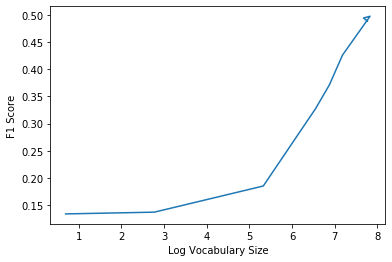

In [14]:
# plot f1 score vs. log vocabulary size
print("F1-Score vs. Log Vocabulary Size")
print("Each point corresponds to a specific L1 regularization used to reduce the vocabulary")
plt.plot(log_vocab, f1_score)
plt.xlabel("Log Vocabulary Size")
plt.ylabel("F1 Score")

Using the full dictionary (26879) with logistic regression gave us f1-score of 0.71 which is significantly higher than what we see when we reduce the vocabulary with regularization (seems to peak around 0.5). It seems to me that for this application (classifying sparse text documents) having the full vocabulary is the better choice. This makes sense as having a small vocabulary just increases the chances we encounter more words in the development set we have never seen before and can't make any judgements from.

### TfidfVectorizer
$$R ratio=\frac{maximum predicted probability}{predicted probability of correct label}$$

In [15]:
def with_tfidf():
    
    # transform training and development data with Tfidf Vectorizer
    vectorizer = TfidfVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    
    # fit logistic regression model wiht L2 regularization = 100
    mod = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty='l2')
    mod.fit(vtrain, train_labels)
    pred_labels = mod.predict(vdev)
    
    # output f1 score of model
    print("Logistic Regression w/ Tfidf Vectorizer\nf1-score: ", metrics.f1_score(dev_labels, pred_labels, average='weighted'))
    print("-"*40)
    
    # using the training data predicted probabilities
    pred_prob = mod.predict_proba(vtrain)
    r_ratio = []
    
    # calculate the r ratio for each document
    for i in range(len(pred_prob)):
        max_prob = max(pred_prob[i])
        cor_prob = pred_prob[i][train_labels[i]]
        r_ratio.append(max_prob / cor_prob)
    
    # index of the three documents with the highest r ratio
    index = np.argsort(r_ratio)[-3:]
    
    # the three documents are empty
    for i in index:
        print("Document Index: ", i, " R Ratio: ", r_ratio[i])
        print("Document Content: ",train_data[i])
        print("Document Length:", len(train_data[i]))
        print("Features: ", vtrain[i].shape)

with_tfidf()

Logistic Regression w/ Tfidf Vectorizer
f1-score:  0.7597662427853104
----------------------------------------
Document Index:  787  R Ratio:  1.4947781282200634
Document Content:  
Document Length: 0
Features:  (1, 26879)
Document Index:  917  R Ratio:  1.4947781282200634
Document Content:  
Document Length: 0
Features:  (1, 26879)
Document Index:  443  R Ratio:  1.4947781282200634
Document Content:  
Document Length: 0
Features:  (1, 26879)


The TF-IDF vectorizer similarly values word counts however it's inverse document frequency adjusts for words that occur frequently generally. This is to avoid over-valuing commonly used words that occur through many documents instead of unique words that would tell us more about the classification.

The r ratio shows the extent to which a particular document's predicted classification was wrong. If the predicted class is the correct one we expect an r ratio of 1.0. The farther it is from 1.0, the more erroneous our prediction is. The top three documents with the highest r ratio all have no content. Since there are no words, it is difficult for the model to adjust even though there are three cases of the same situation. I think there should be some type of weighting/adjustment for the more common labels attributed to all the empty strings.

### Adding class weighting

In [16]:
def with_classweight():
    
    # using the same Logistic Regression model as previous
    
    # transform training and development data with Tfidf Vectorizer
    vectorizer = TfidfVectorizer()
    vtrain = vectorizer.fit_transform(train_data)
    vdev = vectorizer.transform(dev_data)
    
    # fit logistic regression model wiht L2 regularization = 100 
    # added class weighting to adjust weights inversely proportional to class frequencies in training data
    mod = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty='l2', class_weight = 'balanced')
    mod.fit(vtrain, train_labels)
    pred_labels = mod.predict(vdev)
    
    # output f1 score of model
    print("Logistic Regression w/ Tfidf Vectorizer and Weights\nf1-score: ", metrics.f1_score(dev_labels, pred_labels, average='weighted'))
    
with_classweight()

Logistic Regression w/ Tfidf Vectorizer and Weights
f1-score:  0.7716424381858508
